#  <center>ESS 136A Lab 7-8 Seismic Refraction </center>
### <center> Due Mar 2, 2021, 17:00 </center>
## 1. Introduction

The objective of this lab is to analyze the seismic data from the geophone array centered on the Emerson fault near the Landers earthquake. You will use the forward and reverse shots across the geophone line to pick the first arrivals and try fitting the data with 3 different models: 

- (1) Dipping interface 
- (2) Hagedoorn model
- (3) Faulted interface

Details of the 2 interfaces can be found in the book `Looking into the Earth: An Introduction to Geological Geophysics (page 71 and 81)`. Details of Hagedoorn model could be found in the following [link](https://www.eoas.ubc.ca/courses/eosc350/content/methods/meth_6/irregular.html)

Note: This lab can only work in Jupyter notebook or you can lauch it through help > classic notebook from Jupyter Lab. Please remember click the close icon/button when you finish plotting a figure. Otherwise you might have problems to scroll down notebook. Make sure you save the tt1.npy and tt2.npy in a safe place you can find. You will need these two files during the whole lab. 

$\color{red}{\text{I set 8 questions, please filling your answers and run all cells of Jupyter notebook before submission.}}$

$\color{red}{\text{When you finish this lab, you only need to submit this notebook file to CCLE turnin system.}}$



## 2. Read Data and Pick First Arrivals  

To use our seismic data to determine the seismic velocities and the depths of our layers, we first need to pick our first arrivals and create what is called a Slowness diagram, which plots the time of the first arrival (on the y axis) vs. the distance to the station at which the first arrival is recorded. It’s called a slowness diagram, because the axes are inverted relative to the orientation of a velocity diagram, and the slope is therefore the inverse of velocity. This means that steeper slopes correspond to lower velocities.

The data is prepared such that by simply running cells you should be able to automatically create the vectors tt1 and tt2 containing your first arrivals and the geophone numbers for the forward and reverse shots respectively. However, some seismograms we recorded are so noisy that it might be difficult for us to pick the accurate first arrival time. In this case, please refer to the seismograms next to them and try to make the curve smooth.


In [2]:
import matplotlib
%matplotlib  notebook
#calling it a second time may prevent some graphics errors
%matplotlib  notebook

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from obspy.signal.filter import bandpass
from obspy.signal.detrend import polynomial
import math
from scipy.interpolate import interp1d


In [3]:
# parameter set up
nodata = 300  # Number of data points display
dt = 1/1000  # sampling interval
nostations = 48 # number of geophones
dx = 5  # geophone spacing (5m)
rlength = (nostations) * dx # length of geophone line

# nb need to chang later
nb = 2 # the number of branches to be picked in the data

# Read data
seisS1=np.genfromtxt('South/04.txt') #direct wave
seisS2=np.genfromtxt('South/07.txt') #direct wave
tseis1='South'
seis1=np.hstack((seisS1,seisS2))
seisN1=np.genfromtxt('North/01.txt'); #reverse wave
seisN2=np.genfromtxt('North/05.txt'); #reverse wave
tseis2='North'
seis2=np.hstack((seisN1,seisN2))

In [4]:
# plots the forward and reverse seismic sections
def plotseis(seis,doublecolor=False):
    fig =plt.figure(figsize=(9,5))
    ax = fig.add_subplot(111)
    for i in range(nostations):
    #     tr.normalize()
        tr = seis[:nodata,i]
    #     tr = minmax_scale(tr, feature_range=(-1,1))
        tr = polynomial(tr, order=3, plot=False)  
        tr = bandpass(tr,0.1,40,1/dt)
        tr = tr/tr.max()*8
        dist = dx*i+dx
        y = np.arange(nodata)*dt
        x = tr+dist
        ax.plot(x,y,'k')
        ax.fill_betweenx(y,x,dist,x > dist, color='r', alpha = 0.8)
        if doublecolor:
            ax.fill_betweenx(y,x,dist,x < dist, color='b', alpha = 0.8)

    ax.set_xlabel("Station Dist")    
    ax.set_ylabel("sec")    
    ax.set_ylim(0,0.3)
    ax.set_xlim(0,250)
    plt.tight_layout()
    plt.gca().invert_yaxis()
    return fig, ax
    
# pick first arrivals
def onclick(event):
#     tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    if len(picks) == nostations:
        np.save(filename,np.array(sorted(picks)))
        fig.canvas.mpl_disconnect(cid) 
        return 
    picks.append((event.xdata,event.ydata))
    tx = 'button=%d, x=%f, y=%f ' % (len(picks), event.xdata, event.ydata)
    text.set_text(tx)
    plt.plot(event.xdata,event.ydata,'g+',markersize=10,markeredgewidth=2)
    plt.show()


<IPython.core.display.Javascript object>


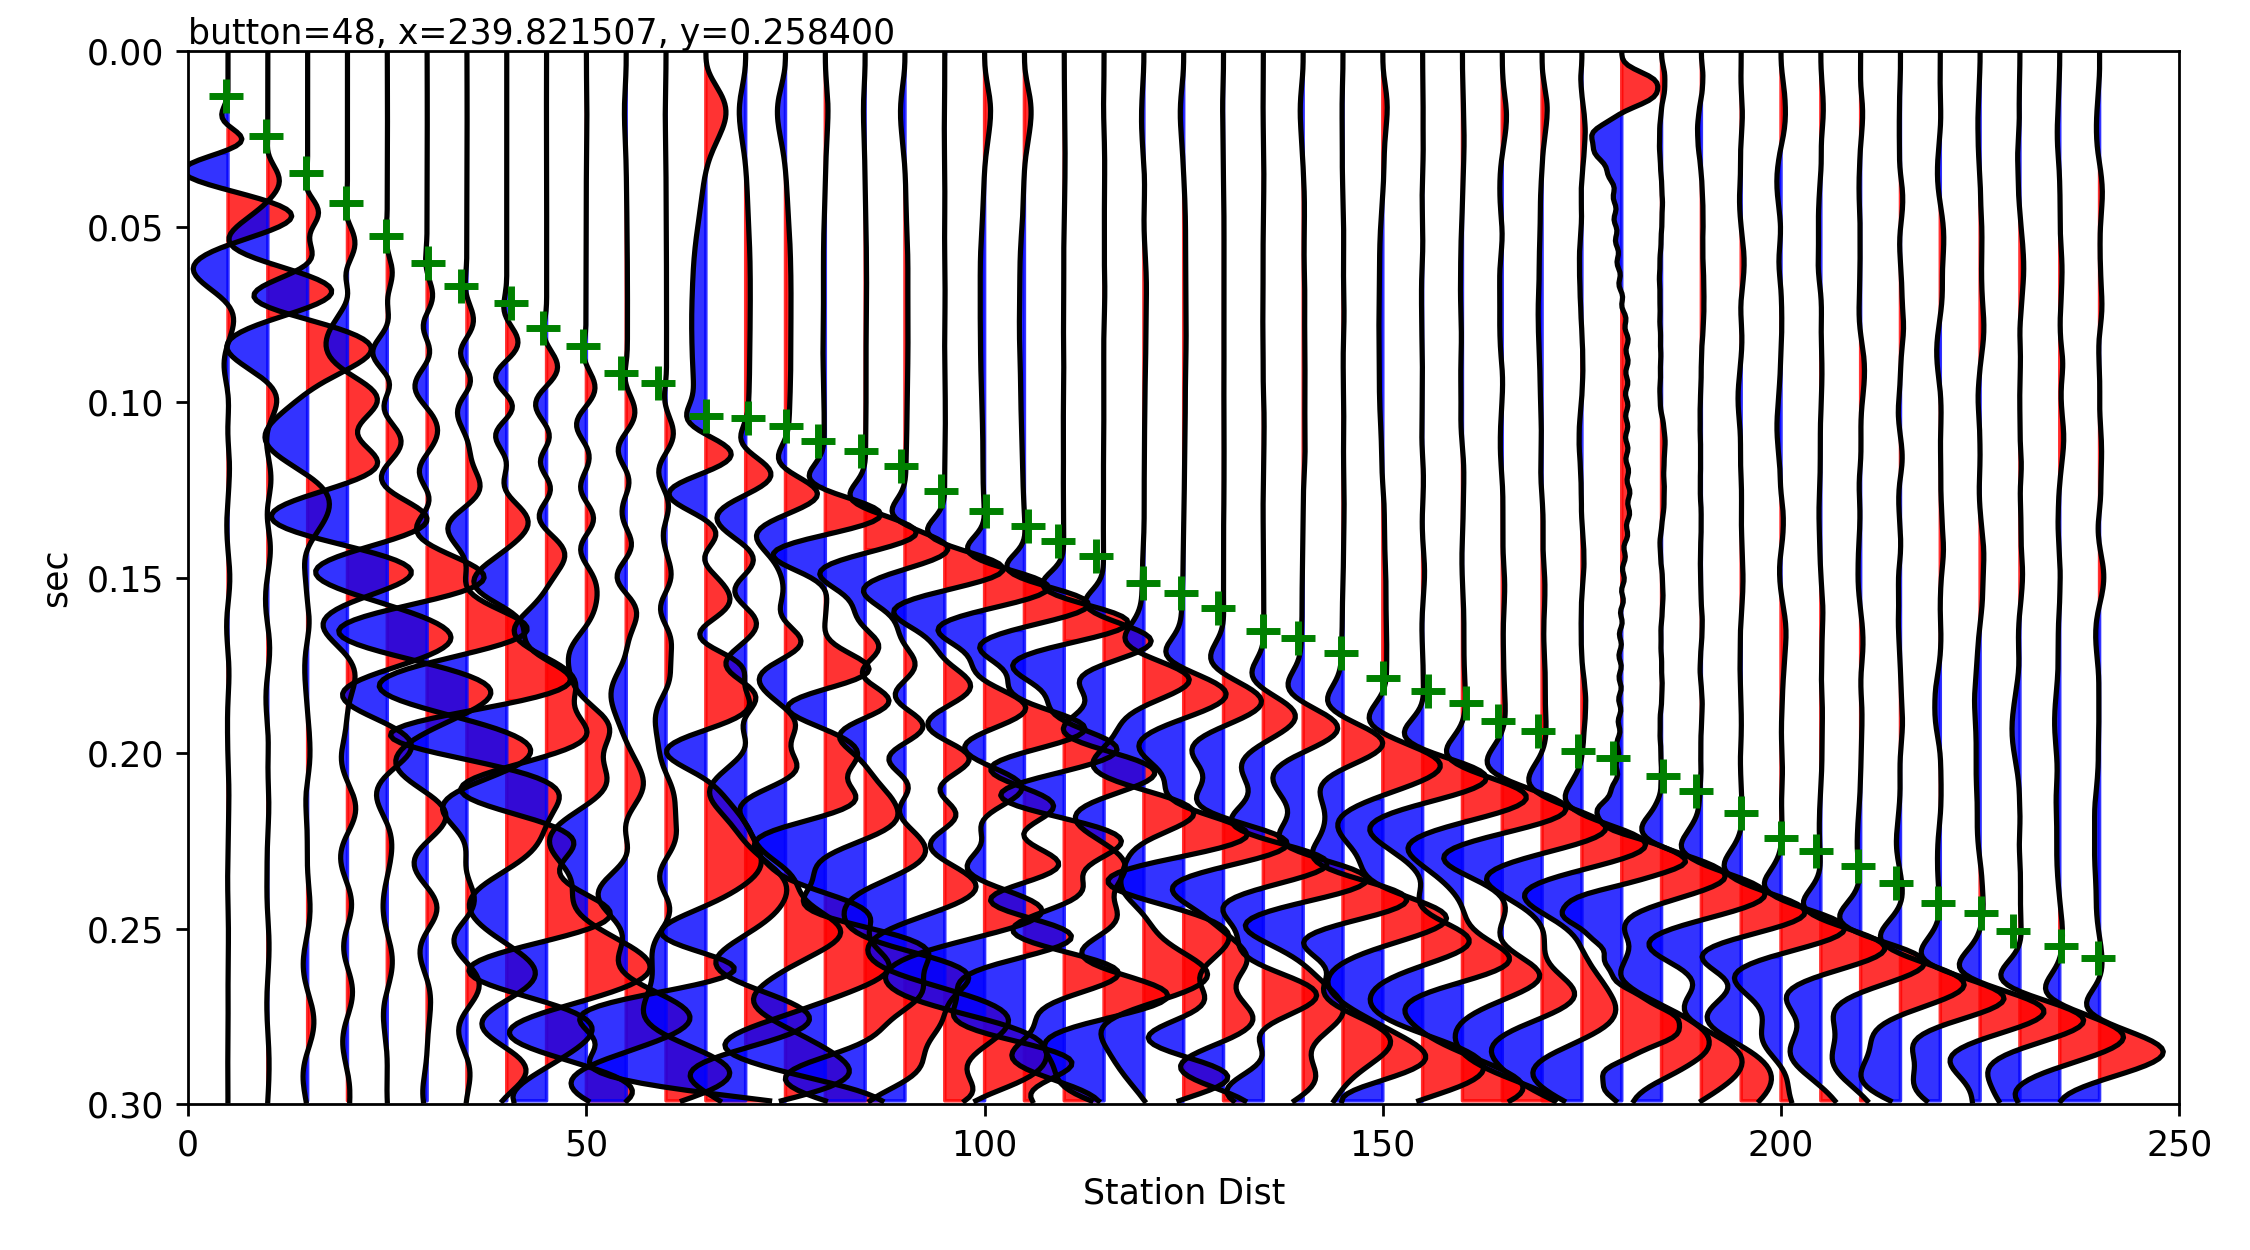

In [5]:
# direct wave
picks=[]
fig, ax =plotseis(seis1,doublecolor=True)
filename='tt1.npy'
text=ax.text(0,0, "", va="bottom", ha="left")
cid = fig.canvas.mpl_connect('button_press_event', onclick)

<IPython.core.display.Javascript object>


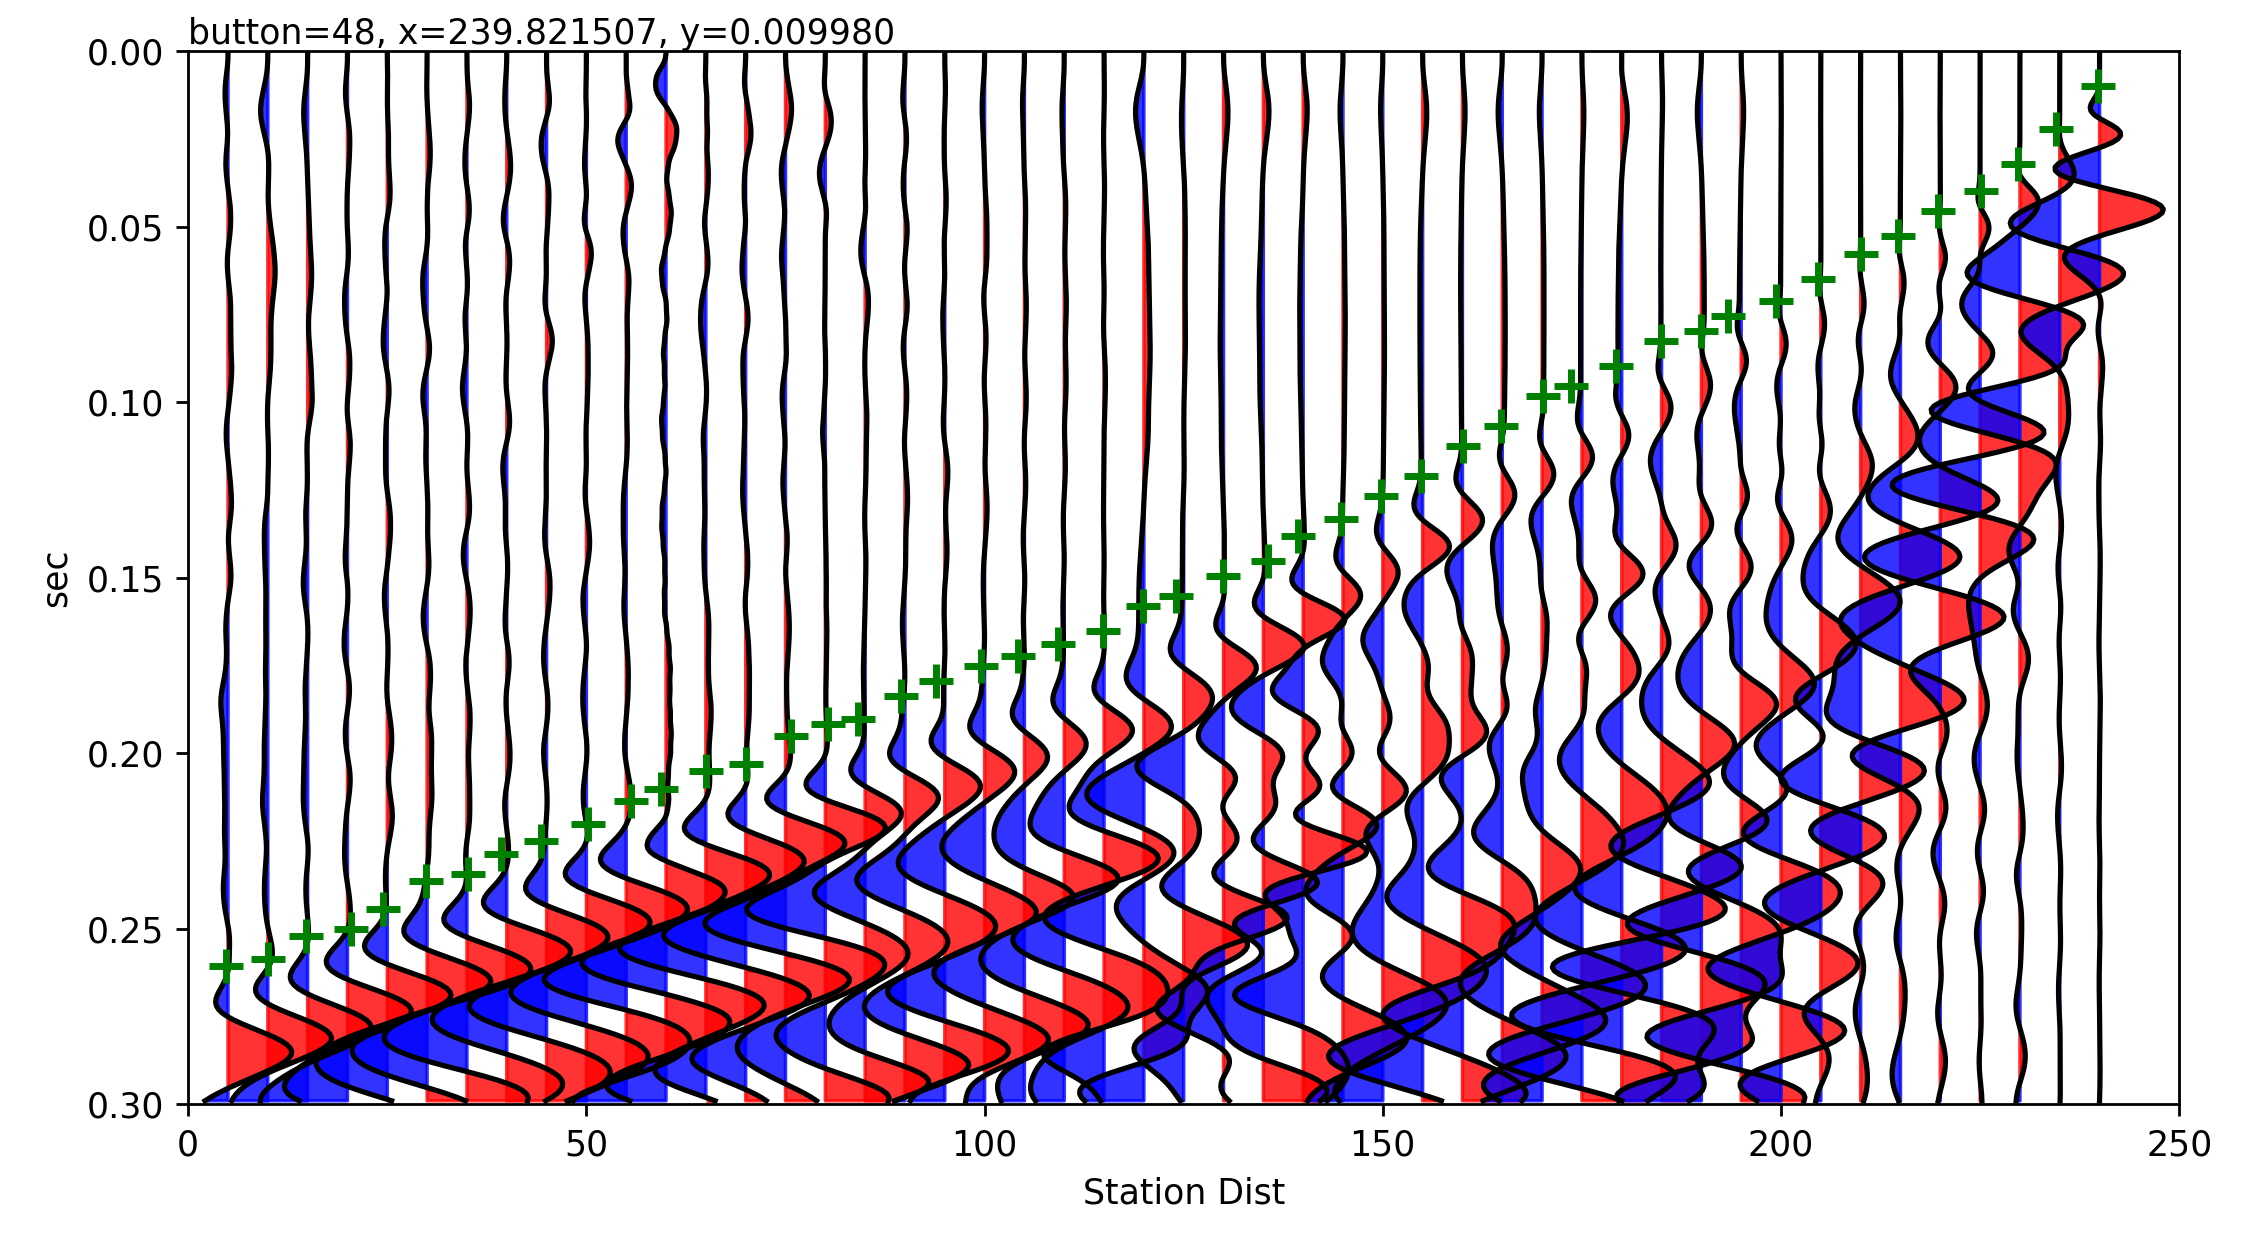

In [6]:
# reverse wave
picks=[]
fig, ax =plotseis(seis2,doublecolor=True)
filename='tt2.npy'
text=ax.text(0,0, "", va="bottom", ha="left")
cid = fig.canvas.mpl_connect('button_press_event', onclick)

## 3. Dipping interface

### 3.1 Obtain velocities and intercepts needed for seisdip

This will plot a slowness diagram of your forward and reverse shots using tt1 first and then tt2. Select 2 branches corresponding to different slopes with mouse clicks. Make sure the lines satisfy the reciprocity property: wave traveling time is the same for the forward and reverse shots (i.e. the line length). You probably will repeat this step many times. This depends on how the Refraction Interpretation figure in the next step would look like. The blue stars are the first arrival picks from the forward model, and the lines will attempt to fit the data. The red stars are the first arrival picks from the reverse model, and the lines attempt to fit the data.

The following cell allows you to time the branches and obtain velocities and intercepts needed for seisdip. You could  set nb to 3 (default value is 2), which determiones the number of branches to be picked in the data. The nb also means the number of layer you would like to set. In this lab, you will first explore 2-layers model, then you can try 3-layers model. __In order to keep both plots of 2-layers and 3-layer models, you can copy and paste code cell of 2.2 and 2.3, and run them seperately with different nb value.__


<IPython.core.display.Javascript object>


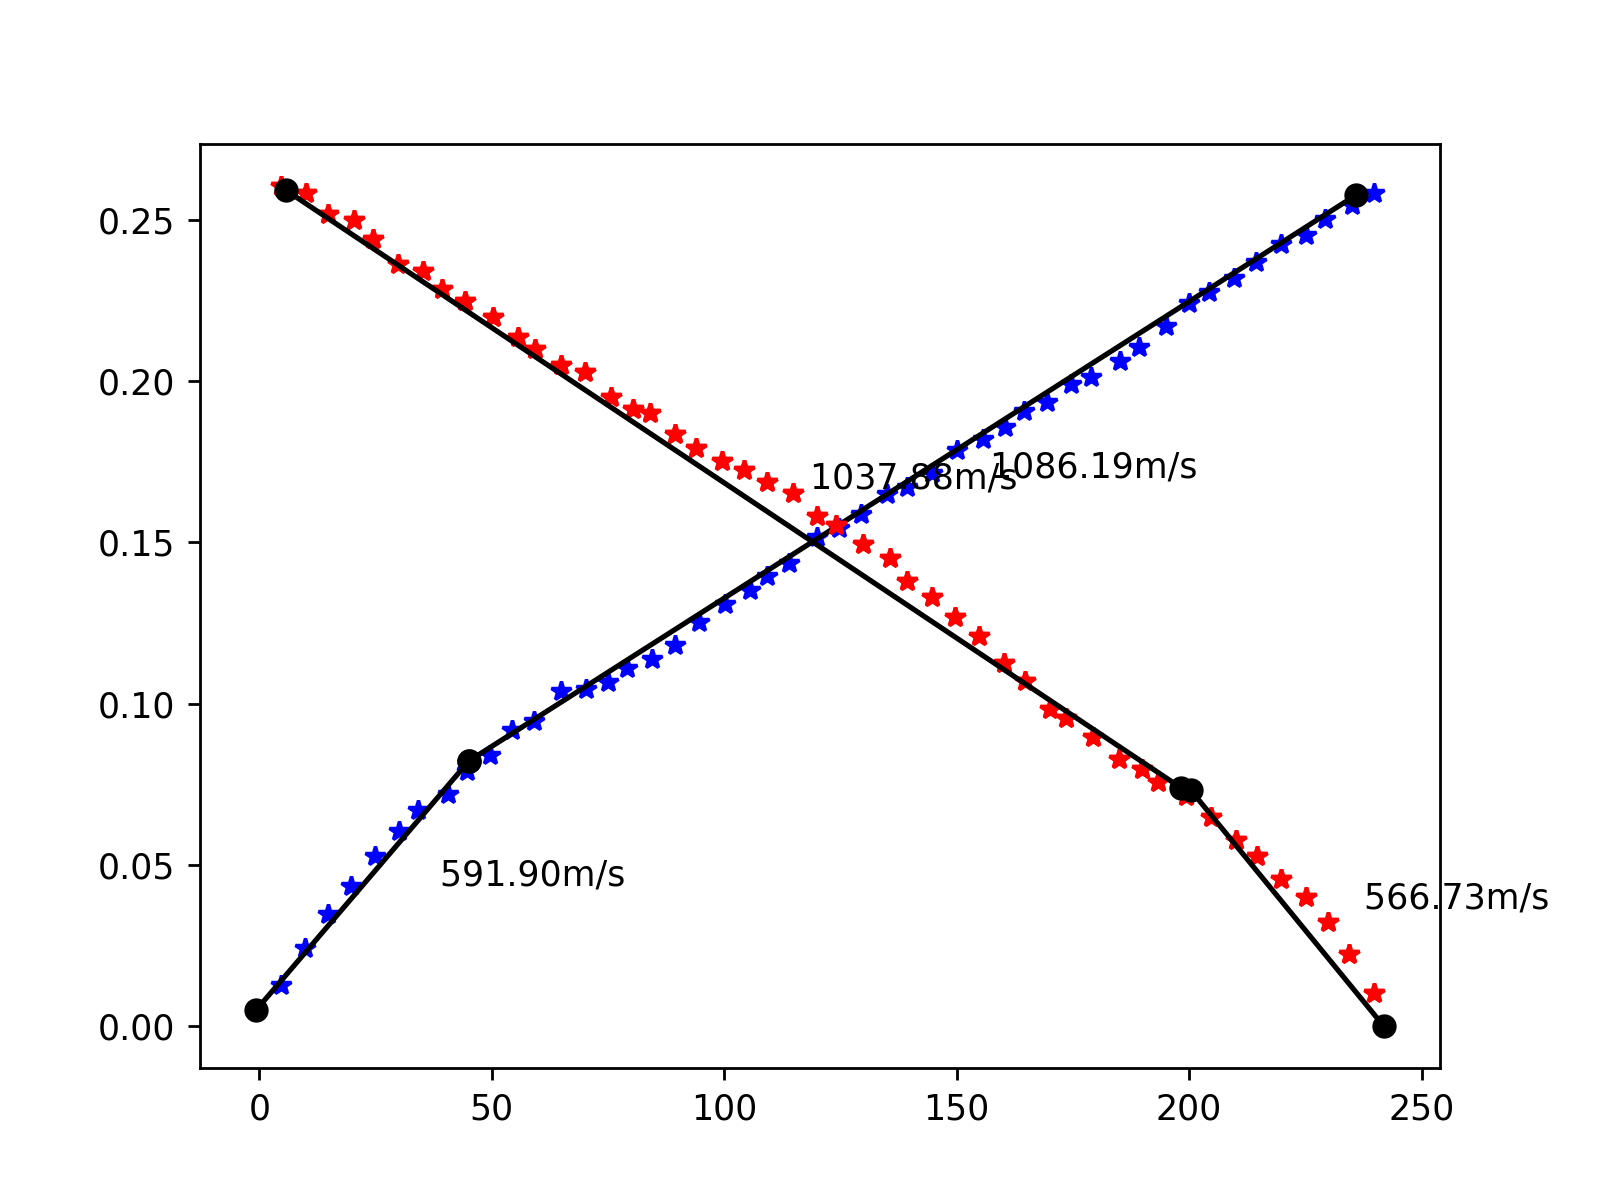

In [4]:
# Keep track of x/y coordinates
# Uncomment it to change nb value
# nb = 3

lines = []
xcoords = []
ycoords = []
tint=[]
vr=[]
def onclick2(event):
    xcoords.append(event.xdata)
    ycoords.append(event.ydata)
    ax.plot(event.xdata,event.ydata,'ko')
    if len(xcoords)==2:
        lines.append(ax.plot(xcoords,ycoords,'k-'))
        x,y=lines[-1][0].get_data()
        p = np.polyfit(x,y, 1)
#         print(p)
        if len(lines)<=nb:
            tint.append(np.polyval(p,0))
        else:
            tint.append(np.polyval(p,rlength))

        vr.append(1/p[0])
        ax.text(np.average(xcoords),np.average(ycoords),'       %.2f'%(abs(1/p[0]))+'m/s')
        xcoords[:] = []
        ycoords[:] = []
    if len(lines)==nb:
        plt.plot(abs(tt2[:,0]),tt2[:,1],'r*')
    # Refresh the plot
    fig.canvas.draw()


fig, ax = plt.subplots()

tt1=np.load('tt1.npy')
tt2=np.load('tt2.npy')

plt.plot(abs(tt1[:,0]),tt1[:,1],'b*')

connection_id = fig.canvas.mpl_connect('button_press_event', onclick2)


### 3.2. Calculate and Visualize Dipping Interface Model

This will plot the Refraction Interpretation calculating the velocities and thicknesses of each layer beneath the receivers. You should get the layers that don’t intersect. The depths and velocities values at the top you will use later.

<IPython.core.display.Javascript object>


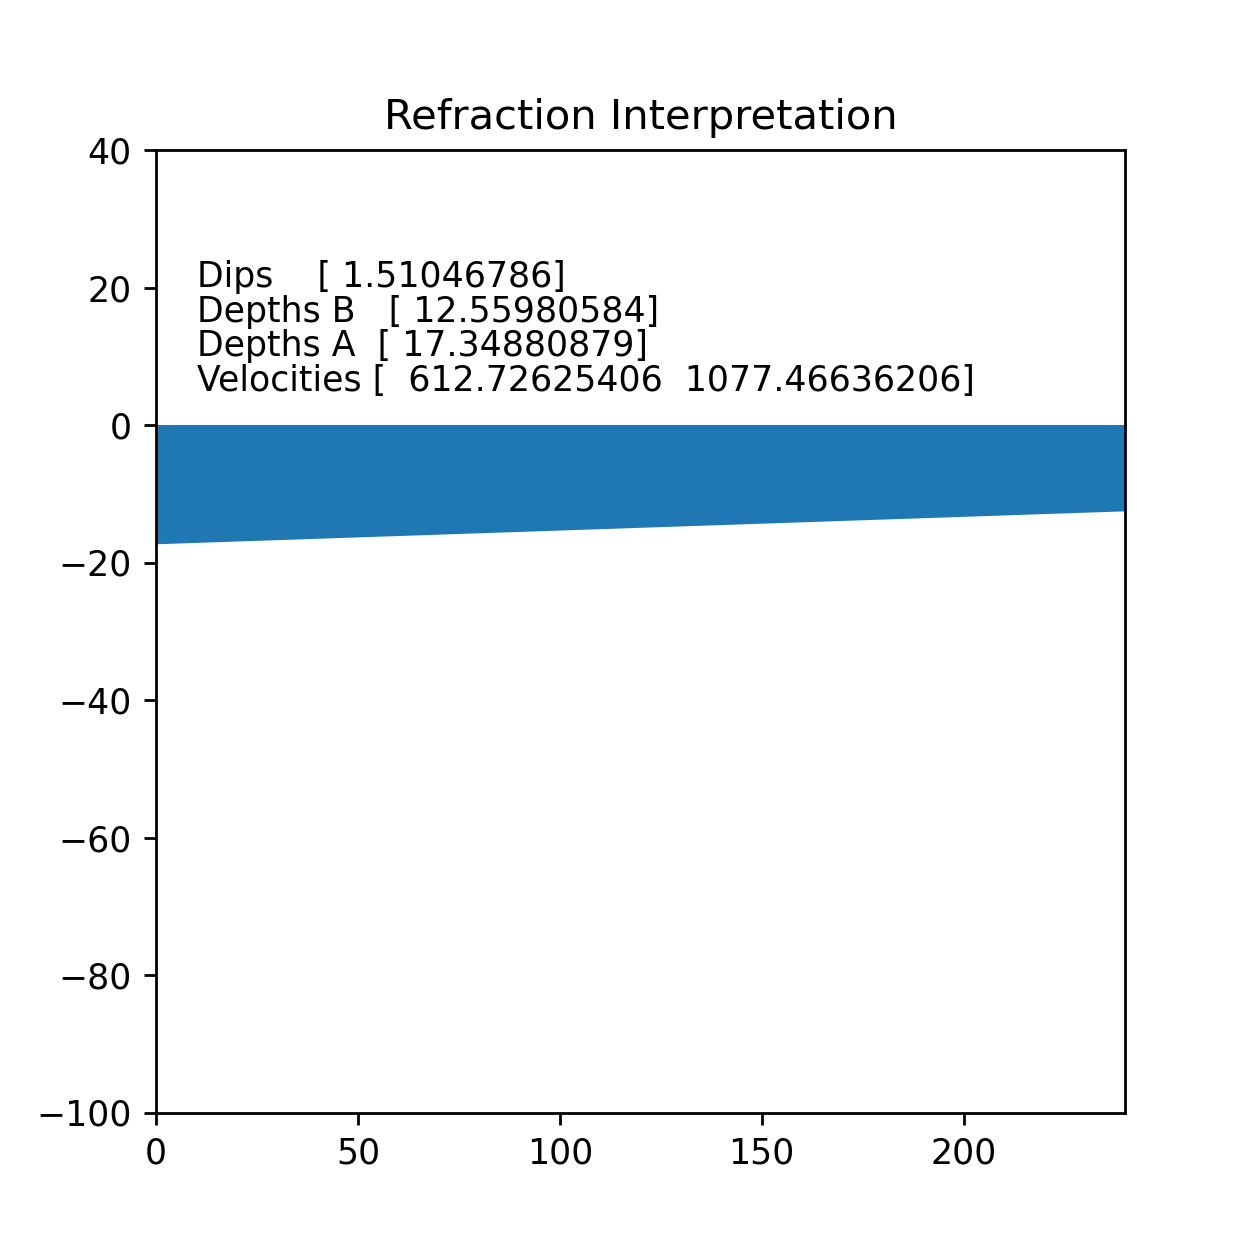

(-100.0, 40.0)

In [8]:
# Testing dataset
# nb=3
# vr =    [0.5297 , 0.8713,    1.1765,
#     -0.5320 ,  -0.9035,   -1.4092]

# tint =  [ -0.0026 ,   0.0284 ,   0.0635,
#      0.0012 ,   0.0412,    0.0958]
# rlength=235

# vr=np.array(vr).reshape((2,-1))*1e3

n=nb                # layers
x=rlength           # length

vr=np.array(vr).reshape((2,-1))
tint=np.array(tint).reshape((2,-1))

tforward=tint[0,-1]+rlength/vr[0,-1]
treverse=tint[1,-1]-rlength/vr[1,-1]
if abs(tforward-treverse)> 0.02:
    print(str(abs(tforward-treverse))+ 'is too big!')
    print('Non Reciprocal DO Previous Step again')

v=np.zeros(n)
w=np.zeros(n)
alph=np.zeros(n-1)
beta=np.zeros(n-1)
a=np.zeros(n-1)
b=np.zeros(n-1)

p=np.zeros(n-1)
q=np.zeros(n-1)
ha=np.zeros(n-1)
hb=np.zeros(n-1)
da=np.zeros(n-1)
db=np.zeros(n-1)

va= vr[0,:nb]
vb=-vr[1,:nb]
tai=tint[0,:nb]
tbi=tint[1,:nb]
tai[0]=0
tbi[0]=0

va[0]=(va[0]+vb[0])/2
vb[0]=va[0]
v[0] = (va[0] + vb[0])*0.5

for m in range(1,n):
    k = 0
    alph[0] = math.asin(v[0]/vb[m])
    beta[0] = math.asin(v[0]/va[m]) 
#     print(vb[m],va[m],alph,beta)
    if m==1:     
        a[0] = (alph[0] + beta[0]) * 0.5 
        w[1] = (alph[0] - beta[0]) * 0.5 
        v[1] = v[0]/np.sin(a[0])
    if m>1:
        while k < 100:
#             print('k',k)
            a[0] = alph[0] - w[1] 
            b[0] = beta[0] + w[1] 
            k = k+1 
            vv = v[k]/v[k-1] 
            p[k] = np.arcsin(vv*math.sin(a[k-1])) 
            q[k] = np.arcsin(vv*math.sin(b[k-1])) 
            if(k+1-m) >=0: 
                break
            a[k] = p[k] - w[k+1] + w[k] 
            b[k] = q[k] + w[k+1] - w[k]
            alph[k] = a[k] + w[k+1] 
            beta[k] = b[k] - w[k+1] 
      
        a[k] = (p[k] + q[k]) * .5;
        b[k] = a[k]
        w[k+1] = w[k] + (p[k] - q[k]) * .5 ;
        alph[k] = a[k] + w[k+1] 
        beta[k] = b[k] - w[k+1]
        v[k+1] = v[k]/math.sin(a[k]);
        
    kk = k-1 
    hha = 0.0 
    hhb = 0.0 
      
    if kk>=0:  
        for i in range(kk+1):
            hh = math.cos(alph[i]) + math.cos(beta[i])
            hh = hh/v[i] 
            hha = hha + hh*ha[i]
            hhb = hhb + hh*hb[i]
            
    r = v[k]/(math.cos(alph[k]) + math.cos(beta[k]))
    ha[k] = r*(tai[k+1] - hha) 
    hb[k] = r*(tbi[k+1] - hhb)
    da[0] = ha[0] 
    db[0] = hb[0] 
      
    if k-1 >= 0:
        da[k] = da[k-1] + ha[k] 
        db[k] = db[k-1] + hb[k]
        
for j  in range(1,n) :
      w[j] = w[j]*57.2958 + 0.001 

        
plt.figure(figsize=(5,5))
for i in range(n-2,-1,-1):
    plt.fill_between([0,rlength,rlength,0],[0,0,-db[i],-da[i]],1)
plt.text(0+10,5,'Velocities '+str(v[:n]))
plt.text(0+10,10,'Depths A  '+str(da[:n-1]))
plt.text(0+10,15,'Depths B   '+str(db[:n-1]))
plt.text(0+10,20,'Dips    '+str(w[1:n]))
plt.title ('Refraction Interpretation')
plt.xlim([0,rlength])
plt.ylim([-100,40])

- __Q1: What's the dip, depth, velocity of your 2-layers dipping interface model?__

`Your answer`

- __Q2: What's the dip, depth, velocity of your 3-layers dipping interface model?__

     (hint: you need to change nb parameter, for example, nb = 3)

`Your answer`

- __Q3: Which one do you think is more reasonable?(Open-ended)__

`Your answer`

## 4. Hagedoorn (Plus-Minus) Model

Run the following cell to calculate the interface depth and velocity using the Hagedoorn/plus-minus method. You will need enter your estimated values for v1 and v2, the velocities in the first and second layers in m/s. (Note the script should be ran twice, and you only take the v2 value from the first run.)

Here we found a good online [reading](https://www.eoas.ubc.ca/courses/eosc350/content/methods/meth_6/irregular.html) which explains the idea of Hagedoorn’s method quite clearly. Please go through the deduction and then answer the following two questions. If you are not familiar with the method to write equations on Markdown, you can review this [link](https://medium.com/analytics-vidhya/writing-math-equations-in-jupyter-notebook-a-naive-introduction-a5ce87b9a214)


- __Q4: How to get the depths under each geophone according to the “plus” term?__

`Your answer`

- __Q5: Why the “minus” term shows a slope of 2/v2?__

`Your answer`


<IPython.core.display.Javascript object>


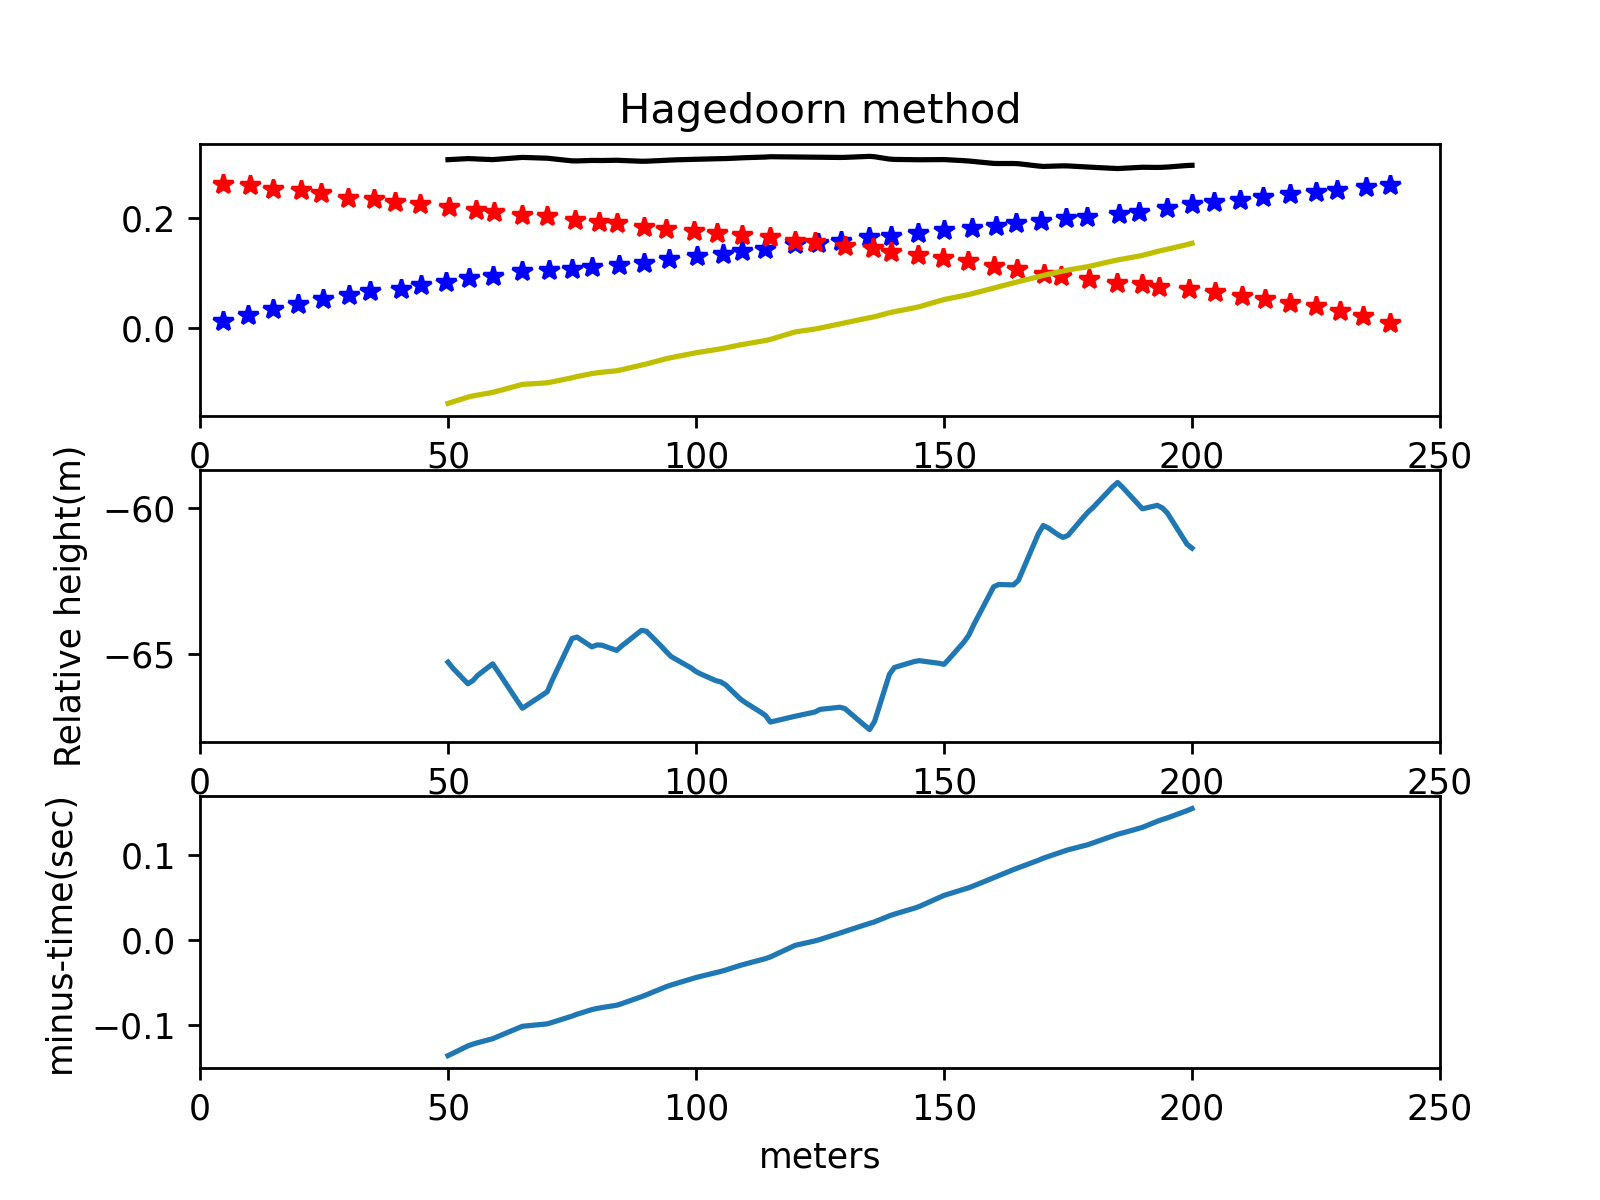

2/slope is 1043.60346254


In [9]:
# Load first arrivals
tt1 = np.load('tt1.npy')
tt2 = np.load('tt2.npy')

dx = 1
# You need to set these two parameters (v1 and v2)
# **********************************************
v1=613   
v2=1025 
# **********************************************
# ttotal: travel time between two end points (averaged by direct and reverse direction)
ttotal = (tt1[-1,1]+tt2[-1,1])/2 
# equation 6.12 in the textbook
fact = v1*v2/math.sqrt(v2**2-v1**2)/2 
ix2 = range(50,201)  
f1 = interp1d(tt1[:,0],tt1[:,1])
t1 = f1(ix2)
f2 = interp1d(tt2[:,0],tt2[:,1])
t2 = f2(ix2)
# Plus
tplus2 = t1+t2
# Minus
tminus2 = t1-t2

# Plotting
plt.figure()
plt.subplot(3,1,1)
plt.title ('Hagedoorn method')
# See figure 6.18 to understand the Plus-minus plots.
plt.plot(abs(tt1[:,0])*dx,tt1[:,1],'b*')
plt.plot(abs(tt2[:,0])*dx,tt2[:,1],'r*')
# Plot plus and minus
plt.plot(ix2,tplus2,'k')
plt.plot(ix2,tminus2,'y')
plt.xlim([0,250])
plt.subplot(3,1,2)
# Plot the relative height of the interface. Use surface as referance. 
plt.plot(ix2,-(tplus2-ttotal)*fact)   
plt.xlim([0,250])
plt.ylabel('Relative height(m)')
plt.subplot(3,1,3)
# The slope of tf-tr should be equal to 2/v2
plt.plot(ix2,tminus2)
plt.xlim([0,250])
plt.xlabel('meters')
plt.ylabel('minus-time(sec)')
P = np.polyfit(ix2,tminus2,1)

print('2/slope is',2/P[0])

- __Q6: What's V1 and V2 in your final model?__

`Your answer`

## 5. Faulted Interface Model

For the faulted interface model, simply run the following cell.Similar to the gravity labs, we want the model fit the data better by tuning some parameters in the model. There are 5 parameters we need to adjust in this case: v1, v2, h, t, and xF. You can use the results of the dipping layer model as initial guess for v1, v2, h, t, and xF.

<IPython.core.display.Javascript object>


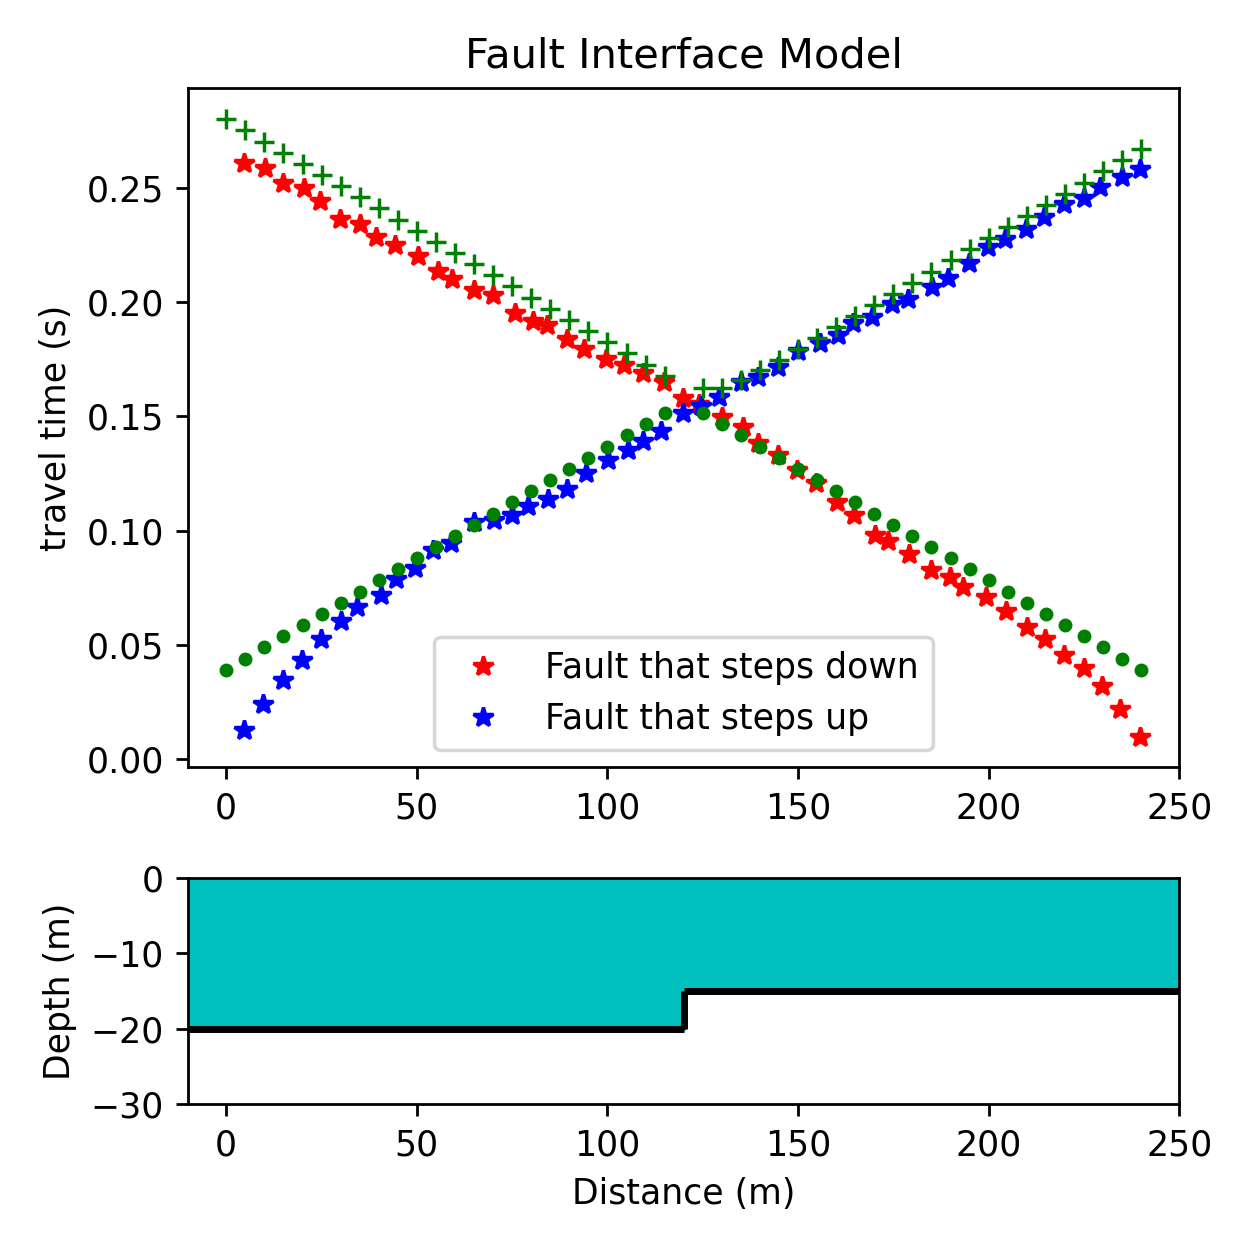

In [49]:
# enter the estimated values based on the previous plot 
# (Hagedoorn/dipping interface) and the Refraction Interpretation figure

# You need to set these parameters (v1, v2, h, t, and xF)
# ******************************************************
# the velocities in the first and second layers in m/s
v1 = 613   
v2 = 1025  
# fault x coordinate, distance from the first geophone
xF= 120 
# first layer, meters. From the lower side
h= 15
# throw of the fault, meters
t= 5
# *******************************************************

H = t+h
thc = np.arcsin(v1/v2)
x1 = np.arange(0, xF, 5)
x2 = np.arange(xF+5, 241, 5) 

# Fault that steps down
T1 = x1/v2 + 2 * h * np.cos(thc) / v1
xx = xF - h * np.tan(thc)
zz = x2 - H * np.tan(thc) - xF
T2 = h/(v1*np.cos(thc)) + 1/v2*np.sqrt(xx**2+t**2) \
    + zz/v2 + H/(v1*np.cos(thc))
    
# fault that steps up
T3 = x1/v2 + 2 * h * np.cos(thc) / v1
xx2 = x2 - (h-t) * np.tan(thc) - xF
T4 = 2*h/(v1*np.cos(thc)) + 1/v2*(xF-h*np.tan(thc)) \
    + 1/v2*np.sqrt(xx2**2 + t**2) - t/(v1*np.cos(thc))

# plot figure
plt.figure(figsize=(5,5)) 
gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])

# Picked first arrivals
ax0.plot(tt2[:,0],tt2[:,1],'r*')
ax0.plot(tt1[:,0],tt1[:,1],'b*')
# steps down model
ax0.plot(240-x1,T1,'g.')
ax0.plot(240-x2,T2,'g+')
# steps up model
ax0.plot(x1,T3,'g.')
ax0.plot(x2,T4,'g+')
ax0.set_ylabel('travel time (s)')
ax0.set_title('Fault Interface Model')
ax0.set_xlim([-10,250])

plt.legend (['Fault that steps down','Fault that steps up'])
ax1 = plt.subplot(gs[1])
ax1.hlines(-H,-10,xF,'k',lw=2)
ax1.hlines(-h,xF,250,'k',lw=2)
ax1.vlines(xF,-H,-h,'k',lw=2)
ax1.fill_between([-10,250,250,-10],[0,0,-h,-h],1,color='c')
ax1.fill_between([-10,xF,xF,-10],[0,0,-H,-H],1,color='c')
ax1.set_ylim([-30,0])
ax1.set_xlim([-10,250])
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel('Distance (m)')

plt.tight_layout()

- __Q7: What's v1, v2, h, t, and xF in your final model?__

`Your answer`

- __Q8: Please compare dipping layer, Hagedoorn, and faulted interface method? Explain what structure you can see from the results.__

`Your answer`
